In [40]:
# load required packages 

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os 
import seaborn as sns

#for maps
import folium
from folium.plugins import HeatMap

#for imputation
import sklearn
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

In [85]:
# load metadata data
metadata = pd.read_csv("coughvid_V3/metadata_compiled.csv")
print(metadata.dtypes)
metadata.head()


Unnamed: 0                 int64
uuid                      object
datetime                  object
cough_detected           float64
latitude                 float64
longitude                float64
age                      float64
gender                    object
respiratory_condition     object
fever_muscle_pain         object
status                    object
status_SSL                object
quality_1                 object
cough_type_1              object
dyspnea_1                 object
wheezing_1                object
stridor_1                 object
choking_1                 object
congestion_1              object
nothing_1                 object
diagnosis_1               object
severity_1                object
quality_2                 object
cough_type_2              object
dyspnea_2                 object
wheezing_2                object
stridor_2                 object
choking_2                 object
congestion_2              object
nothing_2                 object
diagnosis_

,Unnamed: 0,uuid,datetime,cough_detected,latitude,longitude,age,gender,respiratory_condition,fever_muscle_pain,...,quality_4,cough_type_4,dyspnea_4,wheezing_4,stridor_4,choking_4,congestion_4,nothing_4,diagnosis_4,severity_4
0,0,00014dcc-0f06-4c27-8c7b-737b18a2cf4c,2020-11-25T18:58:50.488301+00:00,0.0155,48.9,2.4,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,00039425-7f3a-42aa-ac13-834aaa2b6b92,2020-04-13T21:30:59.801831+00:00,0.9609,31.3,34.8,15.0,male,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,0007c6f1-5441-40e6-9aaf-a761d8f2da3b,2020-10-18T15:38:38.205870+00:00,0.1643,NaN,NaN,46.0,female,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,00098cdb-4da1-4aa7-825a-4f1b9abc214b,2021-01-22T22:08:06.742577+00:00,0.1133,47.4,9.4,66.0,female,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,0009eb28-d8be-4dc1-92bb-907e53bc5c7a,2020-04-12T04:02:18.159383+00:00,0.9301,40.0,-75.1,34.0,male,True,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


/var/folders/b9/sb1t5vg905lcqnv0bbs7jl600000gn/T/ipykernel_36244/3511857282.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='gender', data=metadata, palette='viridis')
/var/folders/b9/sb1t5vg905lcqnv0bbs7jl600000gn/T/ipykernel_36244/3511857282.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='respiratory_condition', data=metadata, palette='coolwarm')
/var/folders/b9/sb1t5vg905lcqnv0bbs7jl600000gn/T/ipykernel_36244/3511857282.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='fever_muscle_pain', data=metadata, palette='

<Axes: xlabel='cough_type_4', ylabel='count'>

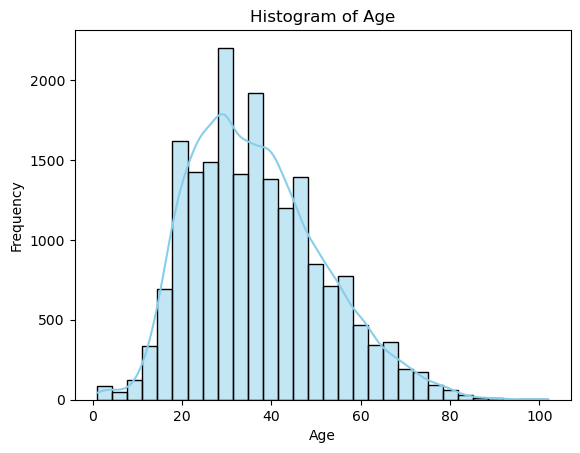

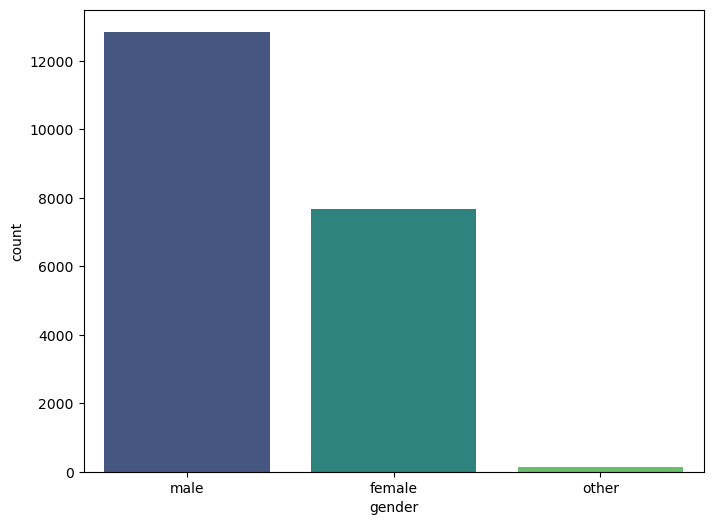

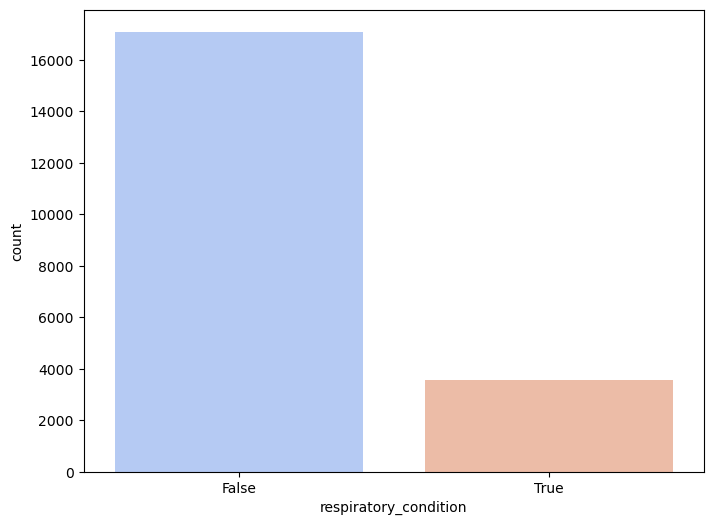

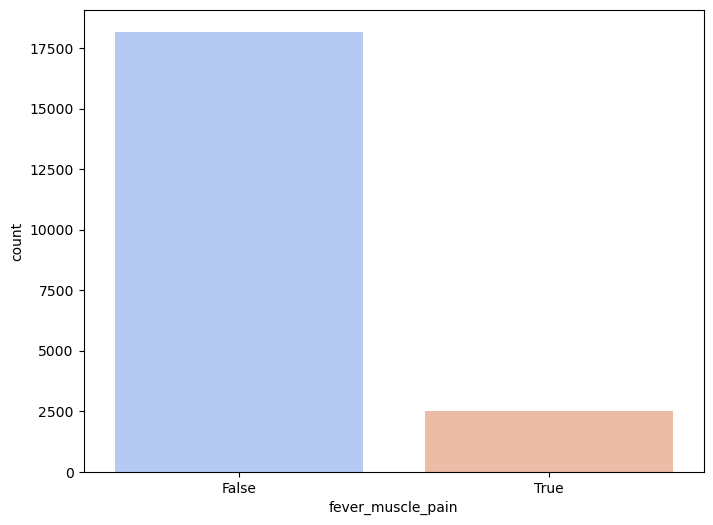

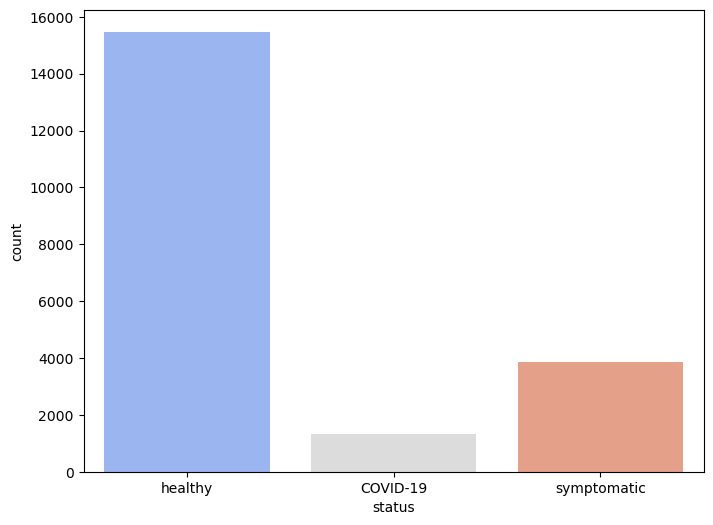

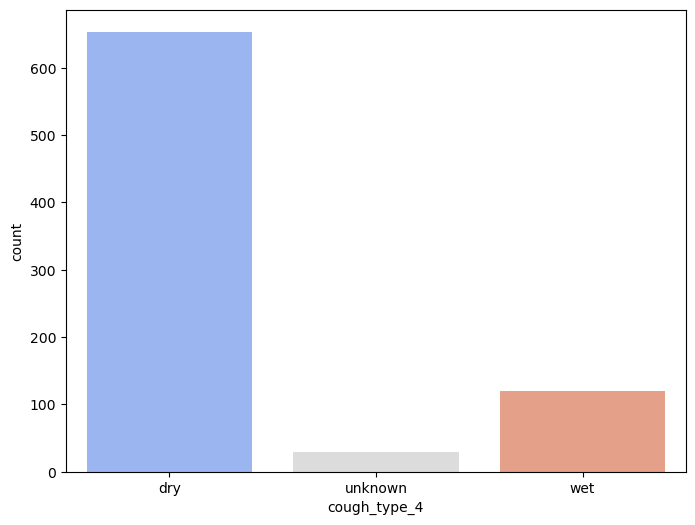

In [86]:
# EDA 

sns.histplot(metadata['age'].dropna(), bins=30, kde=True, color='skyblue')
plt.title('Histogram of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')

plt.figure(figsize=(8, 6))
sns.countplot(x='gender', data=metadata, palette='viridis')

plt.figure(figsize=(8, 6))
sns.countplot(x='respiratory_condition', data=metadata, palette='coolwarm')

plt.figure(figsize=(8, 6))
sns.countplot(x='fever_muscle_pain', data=metadata, palette='coolwarm')

plt.figure(figsize=(8, 6))
sns.countplot(x='status', data=metadata, palette='coolwarm')

plt.figure(figsize=(8, 6))
sns.countplot(x='cough_type_4', data=metadata, palette='coolwarm')





In [87]:
# concat physician data from different ppl
## this code excludes individuals who dont have physician annotated coughs 
### individuals who have been assessed by more than one physician, it only includes the last person to assess them 

def reshape_metadata(metadata):
    rows = [] 
    for _, row in metadata.iterrows():
        for i in range(1, 5):  
            if pd.notna(row[f'quality_{i}']):  
                new_row = {
                    'uuid': row['uuid'],
                    'datetime': row['datetime'],
                    'cough_detected': row['cough_detected'],
                    'latitude': row['latitude'],
                    'longitude': row['longitude'],
                    'age': row['age'],
                    'gender': row['gender'],
                    'respiratory_condition': row['respiratory_condition'],
                    'fever_muscle_pain': row['fever_muscle_pain'],
                    'status': row['status'],
                    'status_SSL': row['status_SSL'],
                    'quality': row[f'quality_{i}'],
                    'cough_type': row[f'cough_type_{i}'],
                    'dyspnea': row[f'dyspnea_{i}'],
                    'wheezing': row[f'wheezing_{i}'],
                    'stridor': row[f'stridor_{i}'],
                    'choking': row[f'choking_{i}'],
                    'congestion': row[f'congestion_{i}'],
                    'nothing': row[f'nothing_{i}'],
                    'diagnosis': row[f'diagnosis_{i}'],
                    'severity': row[f'severity_{i}'],
                    'physician_id': i
                }
                rows.append(new_row)

    metadata_new = pd.DataFrame(rows)
    metadata_new.fillna('unknown', inplace=True)
    return metadata_new

metadata_new = reshape_metadata(metadata)
print(metadata_new.head())
print(metadata_new.shape)


                                   uuid                          datetime  \
0  0029d048-898a-4c70-89c7-0815cdcf7391  2020-07-16T03:01:55.059762+00:00   
1  002db0bd-e57f-4c30-ade0-16640d424eb7  2020-04-13T19:51:11.397697+00:00   
2  005b8518-03ba-4bf5-86d2-005541442357  2020-04-14T20:16:53.677536+00:00   
3  006d8d1c-2bf6-46a6-8ef2-1823898a4733  2020-04-22T10:24:21.408615+00:00   
4  008ba489-31ad-44d8-856b-fcf72369dc46  2020-04-13T23:09:36.585124+00:00   

   cough_detected latitude longitude      age   gender respiratory_condition  \
0          0.9456  unknown   unknown     35.0     male                  True   
1          0.9536  unknown   unknown  unknown  unknown               unknown   
2          0.9854     45.2      19.7     23.0   female                 False   
3          0.2677  unknown   unknown     28.0     male                  True   
4          0.9962     38.1    -122.2     28.0   female                 False   

  fever_muscle_pain       status  ... cough_type dyspnea

/var/folders/b9/sb1t5vg905lcqnv0bbs7jl600000gn/T/ipykernel_36244/2760062466.py:37: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'unknown' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  metadata_new.fillna('unknown', inplace=True)


In [88]:
#make sure variable types are correcct 

metadata_new['age'] = pd.to_numeric(metadata_new['age'], errors='coerce')
metadata_new['latitude'] = pd.to_numeric(metadata_new['latitude'], errors='coerce')
metadata_new['longitude'] = pd.to_numeric(metadata_new['longitude'], errors='coerce')

metadata_new['datetime'] = pd.to_datetime(metadata_new['datetime'], errors='coerce')
metadata_new['datetime'] = metadata_new['datetime'].dt.date

metadata_new['physician_id'] = metadata_new['physician_id'].astype('object')
metadata_new['dyspnea'] = metadata_new['dyspnea'].astype('object')
metadata_new['wheezing'] = metadata_new['wheezing'].astype('object')
metadata_new['stridor'] = metadata_new['stridor'].astype('object')
metadata_new['choking'] = metadata_new['choking'].astype('object')
metadata_new['congestion'] = metadata_new['congestion'].astype('object')
metadata_new['nothing'] = metadata_new['nothing'].astype('object')

metadata_new.dtypes


uuid                      object
datetime                  object
cough_detected           float64
latitude                 float64
longitude                float64
age                      float64
gender                    object
respiratory_condition     object
fever_muscle_pain         object
status                    object
status_SSL                object
quality                   object
cough_type                object
dyspnea                   object
wheezing                  object
stridor                   object
choking                   object
congestion                object
nothing                   object
diagnosis                 object
severity                  object
physician_id              object
dtype: object

In [89]:
#view again to see date format
print(metadata_new.shape)
metadata_new.head()


(3280, 22)


,uuid,datetime,cough_detected,latitude,longitude,age,gender,respiratory_condition,fever_muscle_pain,status,...,cough_type,dyspnea,wheezing,stridor,choking,congestion,nothing,diagnosis,severity,physician_id
0,0029d048-898a-4c70-89c7-0815cdcf7391,2020-07-16,0.9456,NaN,NaN,35.0,male,True,False,symptomatic,...,dry,False,False,False,False,False,True,upper_infection,mild,4
1,002db0bd-e57f-4c30-ade0-16640d424eb7,2020-04-13,0.9536,NaN,NaN,NaN,unknown,unknown,unknown,unknown,...,unknown,False,False,False,False,False,True,healthy_cough,pseudocough,3
2,005b8518-03ba-4bf5-86d2-005541442357,2020-04-14,0.9854,45.2,19.7,23.0,female,False,False,healthy,...,dry,False,False,False,False,False,True,lower_infection,mild,2
3,006d8d1c-2bf6-46a6-8ef2-1823898a4733,2020-04-22,0.2677,NaN,NaN,28.0,male,True,True,symptomatic,...,dry,False,False,False,False,False,True,healthy_cough,pseudocough,1
4,008ba489-31ad-44d8-856b-fcf72369dc46,2020-04-13,0.9962,38.1,-122.2,28.0,female,False,False,healthy,...,wet,False,False,True,False,False,False,lower_infection,mild,3


In [46]:
#mapping out dataset only for ppl that have longitude and latitude data, purely descriptive not for analysis. 

metadata_map = metadata_new.dropna(subset=['latitude', 'longitude'])

map_center = [metadata_map['latitude'].mean(), metadata_map['longitude'].mean()]
map = folium.Map(location=map_center, zoom_start=3)

heat_data = metadata_map[['latitude', 'longitude']].values.tolist()
HeatMap(heat_data, radius=10, blur=15, max_zoom=1).add_to(map)

In [90]:
#drop SSL, longitude and latitude columns for final dataset 

metadata_new = metadata_new.drop(metadata_new.columns[[3, 4, 10]], axis=1)
print(metadata_new.dtypes)

uuid                      object
datetime                  object
cough_detected           float64
age                      float64
gender                    object
respiratory_condition     object
fever_muscle_pain         object
status                    object
quality                   object
cough_type                object
dyspnea                   object
wheezing                  object
stridor                   object
choking                   object
congestion                object
nothing                   object
diagnosis                 object
severity                  object
physician_id              object
dtype: object


uuid                      0.000000
datetime                  0.000000
cough_detected            0.000000
age                       6.358582
gender                    0.000000
respiratory_condition     0.000000
fever_muscle_pain         0.000000
status                    0.000000
quality                   0.000000
cough_type               18.172342
dyspnea                   0.000000
wheezing                  0.000000
stridor                   0.000000
choking                   0.000000
congestion                0.000000
nothing_specific          0.000000
diagnosis                 1.598332
severity                  8.373871
physician_id              0.000000
dtype: float64


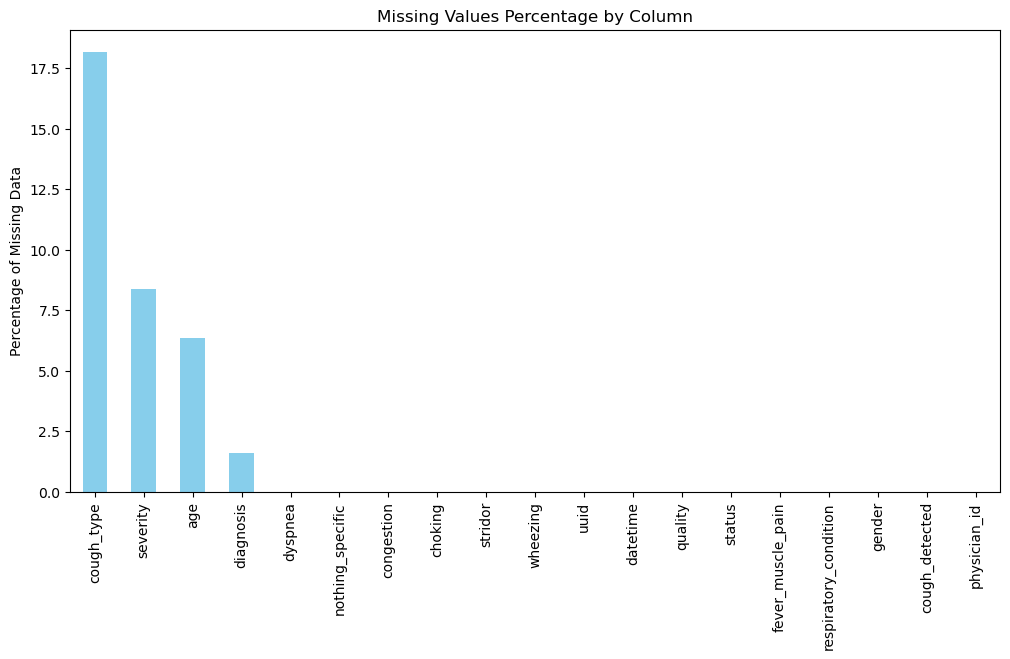

In [108]:
# recode variables and one hot encode all of them before imputing 

## replace unknowns with NAs before missingness analysis 

metadata_new['uuid'] = metadata_new['uuid'].replace('unknown', np.nan)
metadata_new['datetime'] = metadata_new['datetime'].replace('unknown', np.nan)
metadata_new['respiratory_condition'] = metadata_new['respiratory_condition'].replace('unknown', np.nan)
metadata_new['fever_muscle_pain'] = metadata_new['fever_muscle_pain'].replace('unknown', np.nan)
metadata_new['gender'] = metadata_new['gender'].replace('unknown', np.nan)
metadata_new['cough_type'] = metadata_new['cough_type'].replace('unknown', np.nan)
metadata_new['status'] = metadata_new['status'].replace('unknown', np.nan)
metadata_new['quality'] = metadata_new['quality'].replace('unknown', np.nan)
metadata_new['dyspnea'] = metadata_new['dyspnea'].replace('unknown', np.nan)
metadata_new['wheezing'] = metadata_new['wheezing'].replace('unknown', np.nan)
metadata_new['stridor'] = metadata_new['stridor'].replace('unknown', np.nan)
metadata_new['choking'] = metadata_new['choking'].replace('unknown', np.nan)
metadata_new['congestion'] = metadata_new['congestion'].replace('unknown', np.nan)
metadata_new['diagnosis'] = metadata_new['diagnosis'].replace('unknown', np.nan)
metadata_new['severity'] = metadata_new['severity'].replace('unknown', np.nan)
metadata_new['physician_id'] = metadata_new['physician_id'].replace('unknown', np.nan)

# now do NA plot

missing_percentage = metadata_new.isnull().mean() * 100
print(missing_percentage)

plt.figure(figsize=(12, 6))
missing_percentage.sort_values(ascending=False).plot(kind='bar', color='skyblue')
plt.title("Missing Values Percentage by Column")
plt.ylabel("Percentage of Missing Data")
plt.show()

uuid                      object
datetime                  object
cough_detected           float64
age                      float64
gender                     Int64
respiratory_condition      Int64
fever_muscle_pain          Int64
status                    object
quality                   object
cough_type                object
dyspnea                    int64
wheezing                   int64
stridor                    int64
choking                    int64
congestion                 int64
nothing_specific           int64
diagnosis                 object
severity                  object
physician_id              object
dtype: object
                                   uuid    datetime  cough_detected   age  \
0  0029d048-898a-4c70-89c7-0815cdcf7391  2020-07-16          0.9456  35.0   
2  005b8518-03ba-4bf5-86d2-005541442357  2020-04-14          0.9854  23.0   
3  006d8d1c-2bf6-46a6-8ef2-1823898a4733  2020-04-22          0.2677  28.0   
4  008ba489-31ad-44d8-856b-fcf72369dc46  2020-04-13

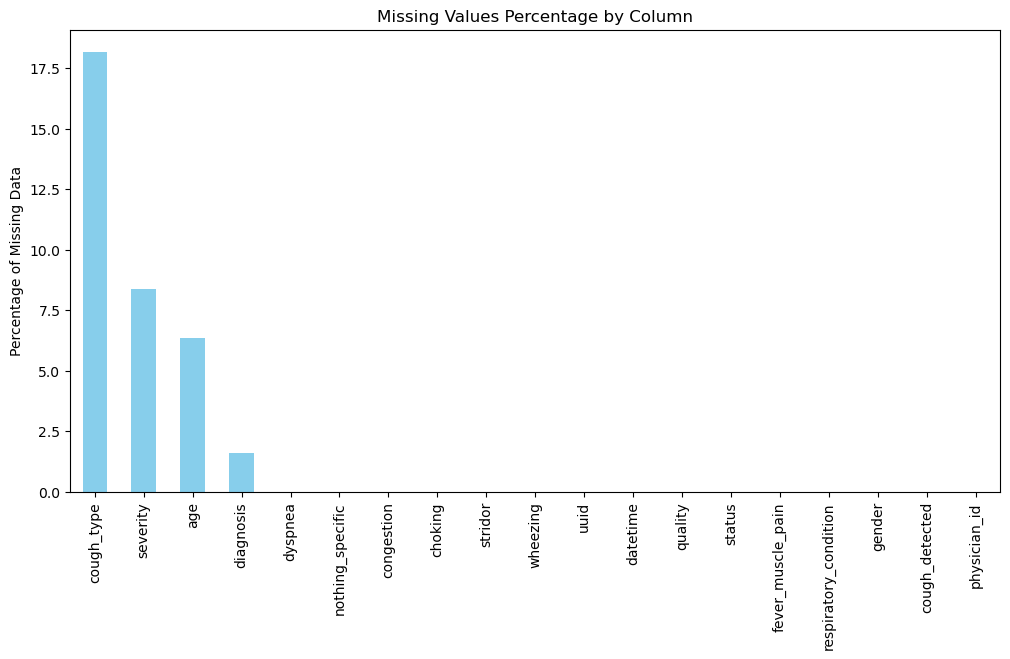

In [109]:
# variable recoding continued 

# Recode gender M = 0/F = 1 and remove people with gender = 'other' and make gender an int variable type

metadata_new['gender'] = metadata_new['gender'].replace({'male': 0, 'female': 1, 'other': 2})
metadata_new = metadata_new[metadata_new['gender'] != 'other']
metadata_new['gender'] = metadata_new['gender'].astype('Int64')

#Rename the nothing column 
metadata_new = metadata_new.rename(columns={'nothing': 'nothing_specific'})

#For true/false variables 
binary_columns = ['respiratory_condition', 'fever_muscle_pain', 'dyspnea', 'wheezing', 'stridor', 'choking', 'congestion', 'nothing_specific']

for col in binary_columns:
    metadata_new[col] = metadata_new[col].replace({False: 0, True: 1})

#convert certain vars to integer - cough detected, resp condition, fever muscle pain

columns_convert = ['respiratory_condition', 'fever_muscle_pain']

for col in columns_convert:
    if col in metadata_new.columns:
        metadata_new[col] = metadata_new[col].astype('Int64')

print(metadata_new.dtypes)
print(metadata_new.head())

missing_percentage = metadata_new.isnull().mean() * 100
print(missing_percentage)

plt.figure(figsize=(12, 6))
missing_percentage.sort_values(ascending=False).plot(kind='bar', color='skyblue')
plt.title("Missing Values Percentage by Column")
plt.ylabel("Percentage of Missing Data")
plt.show()




/var/folders/b9/sb1t5vg905lcqnv0bbs7jl600000gn/T/ipykernel_36244/387670826.py:16: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  metadata_new_encoded[cols_to_convert] = metadata_new_encoded[cols_to_convert].apply(pd.to_numeric, errors='ignore', downcast='integer')


uuid                              object
datetime                          object
cough_detected                   float64
age                              float64
gender                             Int64
respiratory_condition               Int8
fever_muscle_pain                   Int8
dyspnea                          float64
wheezing                         float64
stridor                          float64
choking                          float64
congestion                       float64
nothing_specific                 float64
physician_id_1                   float64
physician_id_2                   float64
physician_id_3                   float64
physician_id_4                   float64
severity_mild                    float64
severity_pseudocough             float64
severity_severe                  float64
severity_nan                     float64
diagnosis_COVID-19               float64
diagnosis_healthy_cough          float64
diagnosis_lower_infection        float64
diagnosis_obstru

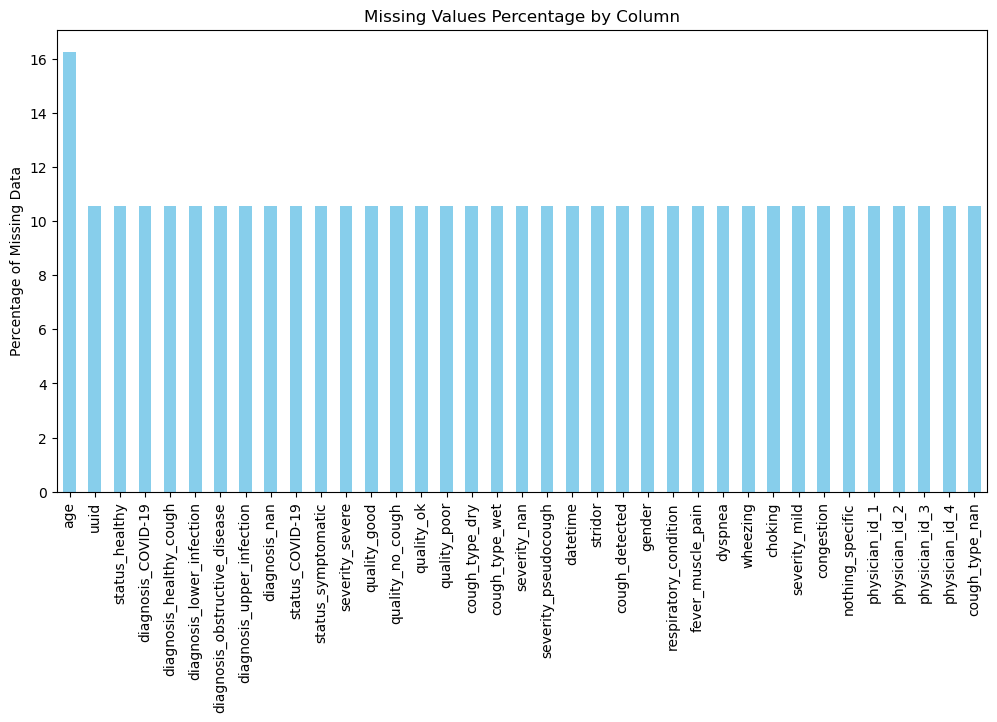

In [111]:

#one hot encode multilevel variables 

encode_cols = ['physician_id', 'severity', 'diagnosis', 'status', 'quality', 'cough_type']
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_df = encoder.fit_transform(metadata_new[encode_cols])

encoded_df = pd.DataFrame(encoded_df, columns=encoder.get_feature_names_out(encode_cols))
metadata_new_encoded = pd.concat([metadata_new, encoded_df], axis=1)

#remove their OG columns from the dataset
metadata_new_encoded = metadata_new_encoded.drop(columns=encode_cols)

#convert float variables to int

cols_to_convert = ['cough_detected', 'respiratory_condition', 'fever_muscle_pain']
metadata_new_encoded[cols_to_convert] = metadata_new_encoded[cols_to_convert].apply(pd.to_numeric, errors='ignore', downcast='integer')


print(metadata_new_encoded.dtypes)
print(metadata_new_encoded.head())


# plot missingness to see if it worked, missing values are represented as all 0s for a one hot encoded variable - CHECK THIS 
missing_percentage = metadata_new_encoded.isnull().mean() * 100
print(missing_percentage)

plt.figure(figsize=(12, 6))
missing_percentage.sort_values(ascending=False).plot(kind='bar', color='skyblue')
plt.title("Missing Values Percentage by Column")
plt.ylabel("Percentage of Missing Data")
plt.show()



In [112]:
# standardise numeric vars before imputation
numeric_cols = ['age', 'cough_detected'] 

scaler = StandardScaler()  
metadata_new_encoded[numeric_cols] = scaler.fit_transform(metadata_new_encoded[numeric_cols])

#make sure all columns have been converted to numeric
print(metadata_new_encoded.dtypes)

#remove non numeric columns to add back after 

uuid_and_datetime = metadata_new_encoded[['uuid', 'datetime']]
metadata_without_uuid_datetime = metadata_new_encoded.drop(columns=['uuid', 'datetime'])

knn_imputer = KNNImputer(n_neighbors=5)
imputed_data = knn_imputer.fit_transform(metadata_without_uuid_datetime)
imputed_df = pd.DataFrame(imputed_data, columns=metadata_without_uuid_datetime.columns)
metadata_preprocessed = pd.concat([uuid_and_datetime, imputed_df], axis=1)

print(metadata_preprocessed.head())



uuid                              object
datetime                          object
cough_detected                   float64
age                              float64
gender                             Int64
respiratory_condition               Int8
fever_muscle_pain                   Int8
dyspnea                          float64
wheezing                         float64
stridor                          float64
choking                          float64
congestion                       float64
nothing_specific                 float64
physician_id_1                   float64
physician_id_2                   float64
physician_id_3                   float64
physician_id_4                   float64
severity_mild                    float64
severity_pseudocough             float64
severity_severe                  float64
severity_nan                     float64
diagnosis_COVID-19               float64
diagnosis_healthy_cough          float64
diagnosis_lower_infection        float64
diagnosis_obstru

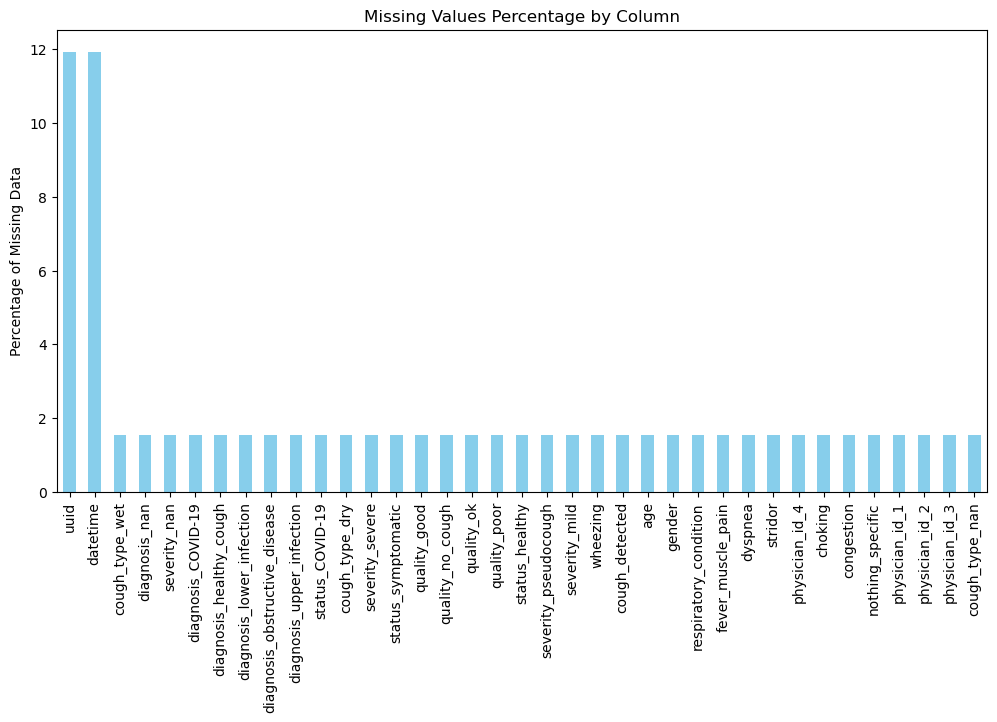

In [113]:
missing_percentage = metadata_preprocessed.isnull().mean() * 100

plt.figure(figsize=(12, 6))
missing_percentage.sort_values(ascending=False).plot(kind='bar', color='skyblue')
plt.title("Missing Values Percentage by Column")
plt.ylabel("Percentage of Missing Data")
plt.show()

In [ ]:
# save file 
print(metadata_preprocessed.shape)

metadata_preprocessed.set_index('uuid', inplace=True)
metadata_preprocessed.to_csv('/Users/danrose/MSc/ML/ML_CW/metadata_preprocessed.csv', index=True)



## DO EXPLORATORY DATA ANALYSIS HERE

